# Decision Tree

## 實際操作

### **Part 1 決策樹分類實作：玻璃類型檢測**

這裡使用UCI的玻璃性質資料  
資料集來源：https://archive.ics.uci.edu/dataset/42/glass+identification

總共有214筆資料，每筆資料都包含9項玻璃化學成分的組成含量，共有4種玻璃類型

輸入特徵：
- Ri (Refractive Index)：玻璃的折射率  
- Na (Sodium)   ：玻璃中的鈉含量  
- Mg (Magnesium)：玻璃中的鎂含量  
- Al (Aluminum) ：玻璃中的鋁含量  
- Si (Silicon)  ：玻璃中的矽含量  
- K  (Potassium)：玻璃中的鉀含量  
- Ca (Calcium)  ：玻璃中的鈣含量  
- Ba (Barium)   ：玻璃中的鋇含量  
- Fe (Iron)     ：玻璃中的鐵含量  

輸出：
- Type 1：窗戶（float processed）
- Type 2：窗戶（non float processed）
- Type 3：車窗（float processed）
- Type 4：車窗（non float processed，資料集中沒有）
- Type 5：容器
- Type 6：餐具
- Type 7：頭燈

我們的目標是應用決策樹演算法，幫助理解模型的預測方式並觀察特徵重要性

In [6]:
#1 載入資料集
import pandas as pd

# 載入資料集
column_names = ["Id", "Ri", "Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe", "Type"]
df_data = pd.read_csv('./Dataset/glass_identification/glass.data', header=None, names=column_names)
df_data = df_data.drop(columns=["Id"])
df_data_raw = df_data.copy()

### 資料視覺化

我們可以查看一下資料的統計分布

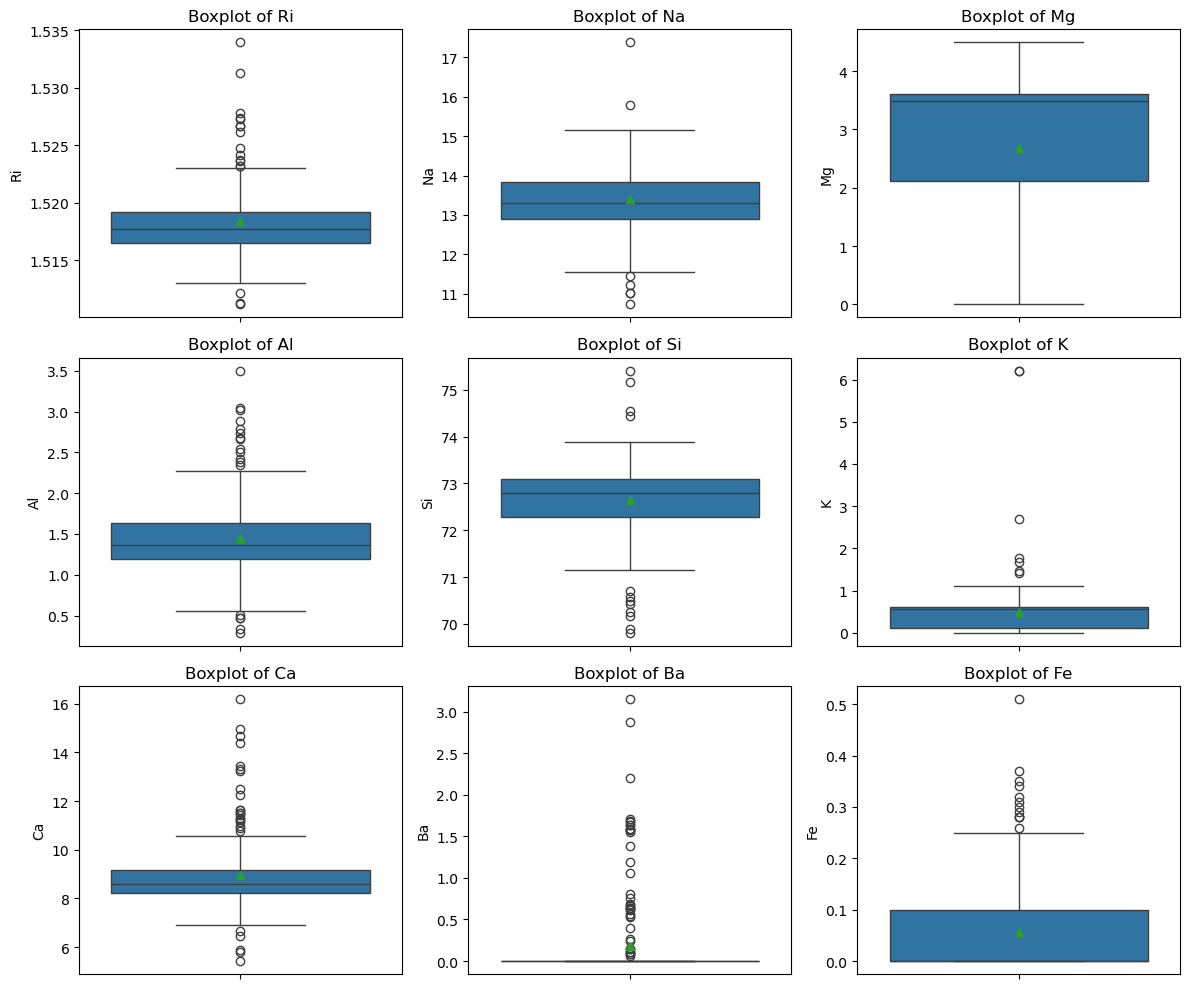

In [9]:
#2 觀察資料統計分布
import matplotlib.pyplot as plt
import seaborn as sns

# 繪製不同特徵的箱型圖
x_feature_names = df_data.columns[:-1]
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
for i, feature in enumerate(x_feature_names):
    row, col = divmod(i, 3)
    sns.boxplot(y=df_data[feature], ax=axes[row, col], showmeans=True)
    axes[row, col].set_title(f'Boxplot of {feature}')

plt.tight_layout()
plt.show()

結果可以發現：
- Si的值比其他都高很多（玻璃主成分）
- 存在很多離群值，需要進行處理

### 資料前處理

再來要進行資料前處理：
- 移除偏移量過大的值
- 篩選主要類別
- 標準化特徵

In [12]:
#3 資料前處理
from sklearn.preprocessing import RobustScaler

# 移除離群值
df_data = df_data[df_data['K'] < 2.5]
df_data = df_data[df_data['Ba'] < 2]
df_data = df_data[df_data['Fe'] < 0.4]

# 篩選主要類別
class_labels = [1, 2, 3, 5, 7]
df_filtered = df_data[df_data['Type'].isin(class_labels)]
x_feature_names = ['Ri', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']
X = df_filtered[x_feature_names].values
y = df_filtered['Type'].values

# 標準化特徵
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

### 分割資料集

接著同樣先將資料集分割成訓練/測試集（7:3）再進行資料前處理

In [14]:
#4 分割資料
from sklearn.model_selection import train_test_split

# 以測試3訓練7分割資料
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Shape of training set X:', X_train.shape)
print('Shape of testing set X:', X_test.shape)

Shape of training set X: (138, 9)
Shape of testing set X: (60, 9)


### 建立模型

接著進行超參數搜尋並建立模型

In [16]:
#5 建立分類決策樹模型
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# 設定超參數範圍
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': list(range(2, 11)),
              'min_samples_split': [2, 4, 6],
              'min_samples_leaf': [1, 2, 3]}

# 網格搜尋
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42),
                           param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)
grid_search.fit(X_train, y_train)

# 建立模型
best_model = grid_search.best_estimator_

print(f"Best Parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2}


### 模型預測與評估

使用搜索完的超棒超參數模型進行預測並評估結果
- 先使用數據查看準確度
- 再繪製混淆矩陣分析分類結果
- 最後進行特徵重要性分析

In [18]:
#6 查看準確度
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = best_model.predict(X_test)
print("Train Accuracy:", best_model.score(X_train, y_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Train Accuracy: 0.8478260869565217
Test Accuracy: 0.5833333333333334

Classification Report:
              precision    recall  f1-score   support

           1       0.63      0.57      0.60        21
           2       0.56      0.65      0.60        23
           3       0.14      0.17      0.15         6
           5       1.00      0.25      0.40         4
           7       1.00      1.00      1.00         6

    accuracy                           0.58        60
   macro avg       0.67      0.53      0.55        60
weighted avg       0.61      0.58      0.58        60



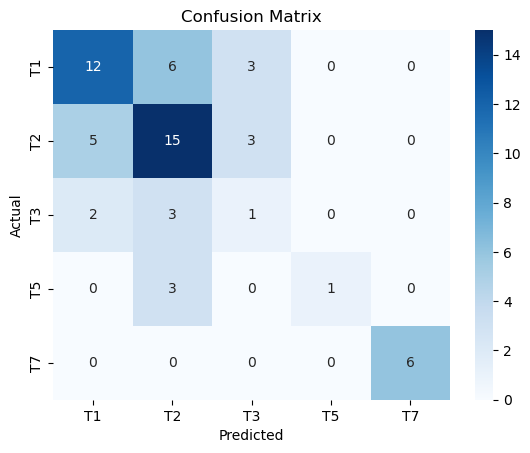

In [20]:
#7 繪製混淆矩陣
class_names = ['T1', 'T2', 'T3', 'T5', 'T7']
cm = confusion_matrix(y_test, y_pred, labels=class_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

結果可以發現：
- 訓練集表現很好，模型有能力擬合資料
- 但測試集表現顯著下降，模型泛化能力差，出現過擬合的現象
- 類別3的表現極差，表示模型幾乎完全無法分類出類別3的樣本
- 類別5和7的表現超好，但幾乎可以肯定是因為樣本數過少

In [30]:
#8 查看特徵重要性
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

print("\nFeature Importances:")
for i in indices:
    print(f"{x_feature_names[i]}: {importances[i]:.4f}")


Feature Importances:
Ba: 0.3166
Al: 0.2122
Ca: 0.1507
Ri: 0.1233
Fe: 0.0848
Si: 0.0767
Mg: 0.0358
K: 0.0000
Na: 0.0000


可以發現Ba和Al的特徵重要性最高，是主要的分別特徵

### 重新分割（處理數據不平衡的問題）

為了處理資料不平衡的問題，重新分割一次並使用class_weight="balanced"

In [46]:
#9 重新分割數據
# 使用stratify
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)

### 重新建立模型

接著重新建立模型

In [49]:
#10 重新建立模型
from sklearn.ensemble import RandomForestClassifier

# 設定超參數範圍
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': list(range(2, 11)),
              'min_samples_split': [2, 4, 6],
              'min_samples_leaf': [1, 2, 3]}

# 建立模型
rf_clf = RandomForestClassifier(class_weight='balanced', random_state=42)

# 網格搜尋
grid_search = GridSearchCV(estimator=rf_clf,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)

# 訓練模型
grid_search.fit(X_resampled, y_resampled)
best_model = grid_search.best_estimator_

print(f"Best Parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2}


### 重新評估模型

In [51]:
#11 重新評估模型
y_pred = best_model.predict(X_test)
print("Train Accuracy:", best_model.score(X_train, y_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Train Accuracy: 0.9347826086956522
Test Accuracy: 0.7833333333333333

Classification Report:
              precision    recall  f1-score   support

           1       0.78      0.67      0.72        21
           2       0.88      0.91      0.89        23
           3       0.29      0.40      0.33         5
           5       1.00      1.00      1.00         3
           7       0.88      0.88      0.88         8

    accuracy                           0.78        60
   macro avg       0.76      0.77      0.76        60
weighted avg       0.80      0.78      0.79        60



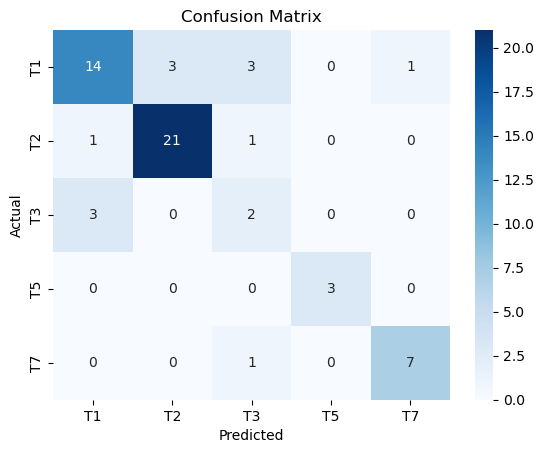

In [58]:
#12 重新繪製混淆矩陣
class_names = ['T1', 'T2', 'T3', 'T5', 'T7']
cm = confusion_matrix(y_test, y_pred, labels=class_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

結果可以發現：
- 測試集的整體準確度上升了20%
- 類別3仍然是最慘的（容易和類別1搞混），但比起剛才也好了不少
- 類別5還是完全正確，樣本數真的太少了（但總資料數太少，用SOMTE沒意義）
- 若要繼續加強的話，應該要增加樹的數量

### **Part 2 決策樹迴歸實作：房價預測**

這次使用scikit-learn的California房價資料練習使用決策樹迴歸預測  
資料集來源：https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html

總共有20640筆資料，每筆資料都包含8個房屋特徵

輸入特徵：
- MedInc：家庭收入的中位數  
- HouseAge：房屋的平均房齡  
- AveRooms：房屋的平均房間數  
- AveBedrms：房屋的平均臥室數  
- Population：人口數  
- AveOccup：房屋的平均居住人數  
- Latitude：房屋所在緯度  
- Longtitude：房屋所在經度  

輸出：
- edHouseVal：房屋價格中位數  

In [56]:
#1 載入資料集
from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)

# 用表格顯示資料
df_data = data.frame
df_data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


### 資料視覺化

用直方圖觀察看看數據分布

<function matplotlib.pyplot.show(close=None, block=None)>

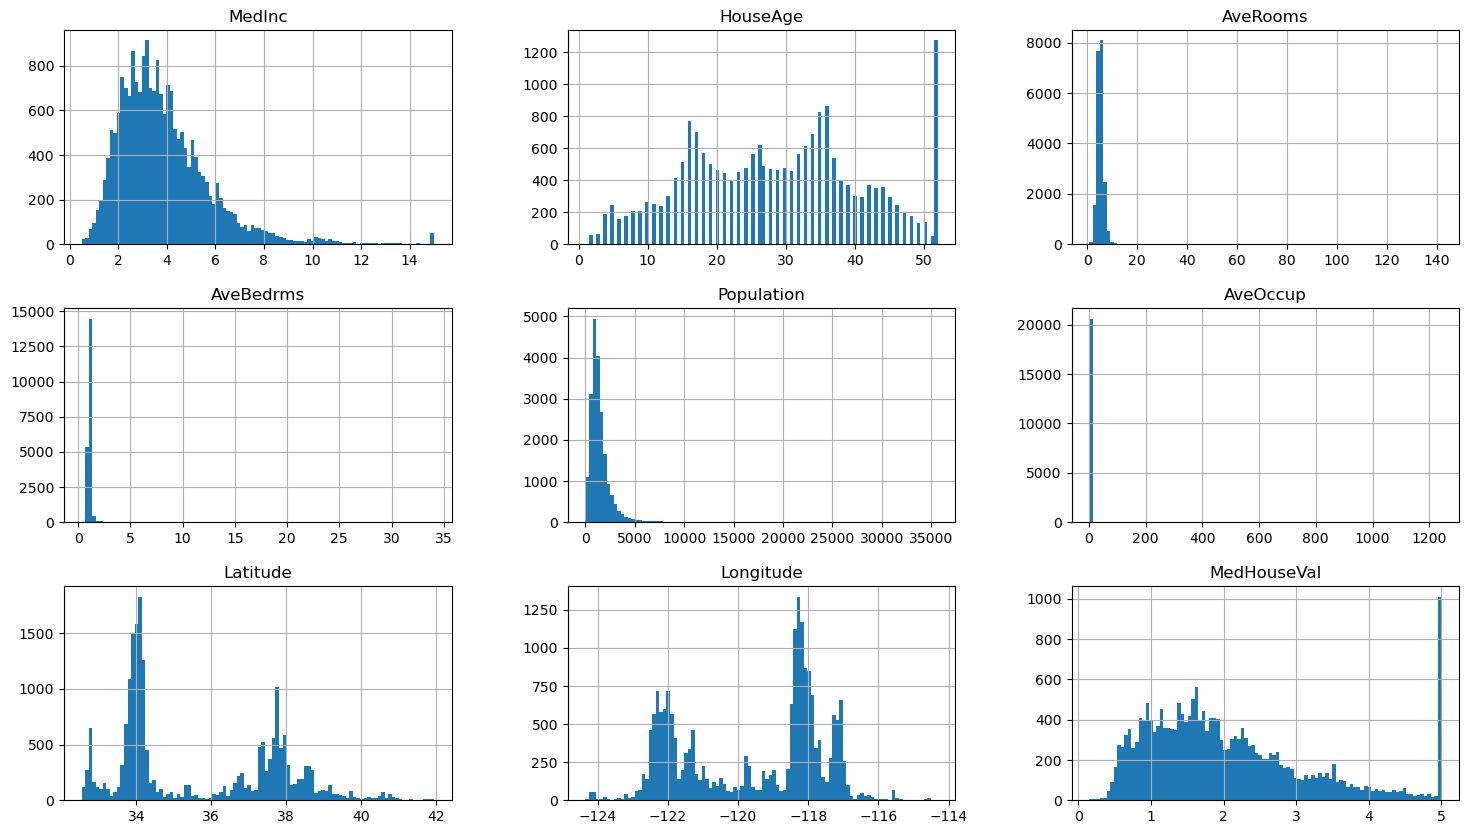

In [41]:
#2 資料視覺化
# 用直方圖顯示資料
df_data.hist(bins=100, figsize=(18,10))
plt.show

結果可以發現：
- MedInc具有長尾分布，數值範圍很廣泛
- AveRooms, AveBedrms, Population, AveOcup的數據分布非常集中

再來特別觀察一下地理位置和房價的關係（理論上會有明顯相關）

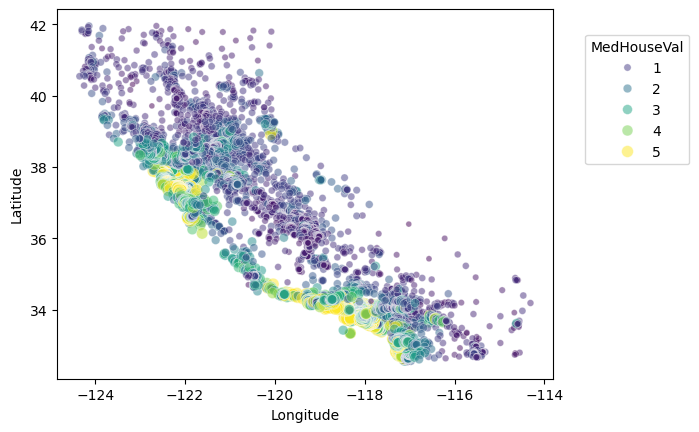

In [62]:
#3 觀察地理位置和房價關係
# 繪製散布圖
sns.scatterplot(data=df_data, x="Longitude", y="Latitude", size="MedHouseVal", hue="MedHouseVal", palette="viridis", alpha=0.5)
plt.legend(title="MedHouseVal", bbox_to_anchor=(1.05, 0.95), loc="upper left")
plt.show()

可以發現：
- 兩者確實有關係，房價較高的房子通常在沿海地區，也就是加州的主要城市（洛杉磯等）  
- 可以進行特徵工程，將經度和緯度結合在一起，形成新的特徵，提供更全面的地理資訊

### 特徵工程

將經度、緯度合併成一個新的特徵

In [64]:
#4 合併位置資訊
df_data['diag_coord'] = (df_data['Longitude'] + df_data['Latitude'])

### 分割資料

接著就可以開始分割資料，分成測試3訓練7

In [67]:
#5 分割資料
# 提取輸入特徵、輸出
X = df_data[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'diag_coord']].values
y = df_data['MedHouseVal'].values

# 以測試3訓練7的比例分割資料
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Shape of training set X: ', X_train.shape)
print('Shape of testing set X: ', X_test.shape)

Shape of training set X:  (14448, 9)
Shape of testing set X:  (6192, 9)


### 建立模型

接著就可以建立模型了

In [72]:
#6 建立迴歸決策樹模型
from sklearn.tree import DecisionTreeRegressor

# 設定參數範圍
param_grid = {'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
              'max_depth': [3, 5, 10, None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

# 網格搜索
grid_search = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1,
                           verbose=1)

# 訓練模型
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}


### 使用模型並評估結果

接著用模型預測並評估結果

In [75]:
#7 評估模型的訓練結果
from sklearn.metrics import mean_squared_error

# 訓練集的評估結果
print("訓練集")
y_train_pred = best_model.predict(X_train)
print("R2 Score: ", best_model.score(X_train, y_train))
print("MSE: ", mean_squared_error(y_train, y_train_pred))

# 測試集的評估結果
print("測試集")
y_test_pred = best_model.predict(X_test)
print("R2 Score: ", best_model.score(X_test, y_test))
print("MSE: ", mean_squared_error(y_test, y_test_pred))

訓練集
R2 Score:  0.8470959582342499
MSE:  0.20484492969277382
測試集
R2 Score:  0.7414286846261263
MSE:  0.3393852221583966


結果可以發現：
- 準確度在測試集和訓練集上都夠高，沒有出現什麼特殊情況

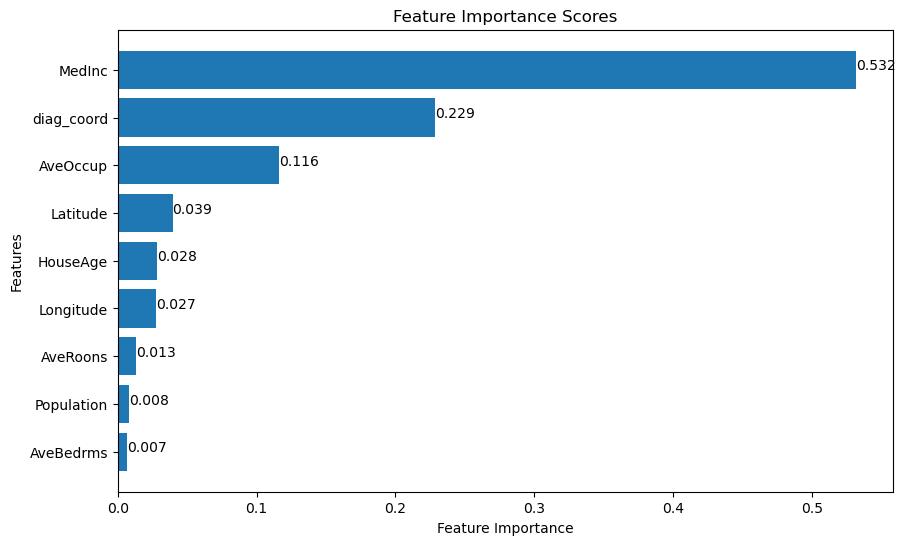

In [78]:
#8 查看特徵重要性
# 提取特徵重要性數值
x_feature_names = ['MedInc', 'HouseAge', 'AveRoons', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'diag_coord']
importances = best_model.feature_importances_
indices = np.argsort(importances)

# 繪製橫向長條圖
plt.figure(figsize=(10, 6))
bar_plot = plt.barh(range(len(x_feature_names)), importances[indices], align='center')
plt.yticks(range(len(x_feature_names)), [x_feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Scores')

for rect in bar_plot:
    width = rect.get_width()
    plt.annotate(f'{width:.3f}', xy=(width, rect.get_y() + rect.get_height()/ 2))
plt.show()

結果可以發現：
- 收入中位數在區分房價時最重要（好現實）